In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/monkeypox-skin-lesion-dataset/Monkeypox_Dataset_metadata.csv
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_02_07.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M53_01_02.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M50_03_04.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_04_07.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_01_09.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_03_13.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M17_02_10.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M50_03_06.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M17_01_13.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_02_10.jpg
/kaggle/input/monkeypox-s

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
save_dir = '/kaggle/working/'
print(f"Using device: {device}")

Using device: cuda


In [4]:
class ContrastiveDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        img1 = self.transform(img)
        img2 = self.transform(img)
        return img1, img2

    def __len__(self):
        return len(self.dataset)

In [5]:
transform = T.Compose([
    T.RandomResizedCrop(size=32),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.5, 0.5, 0.5, 0.5),
    T.RandomGrayscale(p=0.2),
    T.ToTensor()
])

In [6]:
train_dataset = CIFAR10(root='./data', download=True, train=True)
contrastive_dataset = ContrastiveDataset(train_dataset, transform)
train_loader = DataLoader(contrastive_dataset, batch_size=256, shuffle=True)

100%|██████████| 170M/170M [00:04<00:00, 35.3MB/s] 


In [8]:
class SimCLR(nn.Module):
    def __init__(self, base_model, projection_dim=128):
        super(SimCLR, self).__init__()
        self.encoder = base_model
        self.encoder.fc = nn.Identity()
        self.projection_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return projections

model = SimCLR(models.resnet50(pretrained=False)).to(device)


In [9]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    z = F.normalize(z, dim=1)
    similarity = torch.matmul(z, z.T) / temperature
    mask = torch.eye(batch_size * 2, dtype=torch.bool).to(z.device)
    similarity = similarity.masked_fill(mask, -9e15)

    positives = torch.diag(similarity, batch_size) + torch.diag(similarity, -batch_size)
    numerator = torch.exp(positives).repeat(2)
    denominator = torch.exp(similarity).sum(dim=1)

    loss = -torch.log(numerator / denominator).mean()
    return loss

In [15]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
pretext_losses = []
num_pretext_epochs = 50  # Adjust as per runtime availability

for epoch in range(num_pretext_epochs):
    model.train()
    total_loss = 0
    for img1, img2 in tqdm(train_loader, desc=f"Pretext Epoch {epoch+1}"):
        img1, img2 = img1.to(device), img2.to(device)
        z1 = model(img1)
        z2 = model(img2)
        loss = nt_xent_loss(z1, z2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    pretext_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}] Pretext Loss: {avg_loss:.4f}")


Pretext Epoch 1: 100%|██████████| 196/196 [01:36<00:00,  2.03it/s]


Epoch [1] Pretext Loss: 4.2304


Pretext Epoch 2: 100%|██████████| 196/196 [01:36<00:00,  2.04it/s]


Epoch [2] Pretext Loss: 4.2304


Pretext Epoch 3: 100%|██████████| 196/196 [01:35<00:00,  2.05it/s]


Epoch [3] Pretext Loss: 4.2304


Pretext Epoch 4: 100%|██████████| 196/196 [01:35<00:00,  2.04it/s]


Epoch [4] Pretext Loss: 4.2304


Pretext Epoch 5: 100%|██████████| 196/196 [01:36<00:00,  2.04it/s]


Epoch [5] Pretext Loss: 4.2304


Pretext Epoch 6: 100%|██████████| 196/196 [01:35<00:00,  2.05it/s]


Epoch [6] Pretext Loss: 4.2304


Pretext Epoch 7: 100%|██████████| 196/196 [01:36<00:00,  2.03it/s]


Epoch [7] Pretext Loss: 4.2304


Pretext Epoch 8: 100%|██████████| 196/196 [01:36<00:00,  2.03it/s]


Epoch [8] Pretext Loss: 4.2304


Pretext Epoch 9: 100%|██████████| 196/196 [01:36<00:00,  2.03it/s]


Epoch [9] Pretext Loss: 4.2304


Pretext Epoch 10: 100%|██████████| 196/196 [01:36<00:00,  2.03it/s]


Epoch [10] Pretext Loss: 4.2304


Pretext Epoch 11: 100%|██████████| 196/196 [01:36<00:00,  2.02it/s]


Epoch [11] Pretext Loss: 4.2304


Pretext Epoch 12: 100%|██████████| 196/196 [01:36<00:00,  2.04it/s]


Epoch [12] Pretext Loss: 4.2304


Pretext Epoch 13: 100%|██████████| 196/196 [01:36<00:00,  2.04it/s]


Epoch [13] Pretext Loss: 4.2304


Pretext Epoch 14: 100%|██████████| 196/196 [01:35<00:00,  2.04it/s]


Epoch [14] Pretext Loss: 4.2304


Pretext Epoch 15: 100%|██████████| 196/196 [01:35<00:00,  2.06it/s]


Epoch [15] Pretext Loss: 4.2304


Pretext Epoch 16: 100%|██████████| 196/196 [01:34<00:00,  2.06it/s]


Epoch [16] Pretext Loss: 4.2304


Pretext Epoch 17: 100%|██████████| 196/196 [01:35<00:00,  2.04it/s]


Epoch [17] Pretext Loss: 4.2304


Pretext Epoch 18: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]


Epoch [18] Pretext Loss: 4.2304


Pretext Epoch 19: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]


Epoch [19] Pretext Loss: 4.2304


Pretext Epoch 20: 100%|██████████| 196/196 [01:35<00:00,  2.06it/s]


Epoch [20] Pretext Loss: 4.2304


Pretext Epoch 21: 100%|██████████| 196/196 [01:35<00:00,  2.06it/s]


Epoch [21] Pretext Loss: 4.2304


Pretext Epoch 22: 100%|██████████| 196/196 [01:35<00:00,  2.06it/s]


Epoch [22] Pretext Loss: 4.2304


Pretext Epoch 23: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]


Epoch [23] Pretext Loss: 4.2304


Pretext Epoch 24: 100%|██████████| 196/196 [01:35<00:00,  2.06it/s]


Epoch [24] Pretext Loss: 4.2304


Pretext Epoch 25: 100%|██████████| 196/196 [01:36<00:00,  2.03it/s]


Epoch [25] Pretext Loss: 4.2304


Pretext Epoch 26: 100%|██████████| 196/196 [01:36<00:00,  2.04it/s]


Epoch [26] Pretext Loss: 4.2304


Pretext Epoch 27: 100%|██████████| 196/196 [01:35<00:00,  2.04it/s]


Epoch [27] Pretext Loss: 4.2304


Pretext Epoch 28: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]


Epoch [28] Pretext Loss: 4.2304


Pretext Epoch 29: 100%|██████████| 196/196 [01:35<00:00,  2.06it/s]


Epoch [29] Pretext Loss: 4.2304


Pretext Epoch 30: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]


Epoch [30] Pretext Loss: 4.2304


Pretext Epoch 31: 100%|██████████| 196/196 [01:35<00:00,  2.06it/s]


Epoch [31] Pretext Loss: 4.2304


Pretext Epoch 32: 100%|██████████| 196/196 [01:35<00:00,  2.06it/s]


Epoch [32] Pretext Loss: 4.2304


Pretext Epoch 33: 100%|██████████| 196/196 [01:35<00:00,  2.05it/s]


Epoch [33] Pretext Loss: 4.2304


Pretext Epoch 34: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]


Epoch [34] Pretext Loss: 4.2304


Pretext Epoch 35: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]


Epoch [35] Pretext Loss: 4.2304


Pretext Epoch 36: 100%|██████████| 196/196 [01:34<00:00,  2.06it/s]


Epoch [36] Pretext Loss: 4.2304


Pretext Epoch 37: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]


Epoch [37] Pretext Loss: 4.2304


Pretext Epoch 38: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]


Epoch [38] Pretext Loss: 4.2304


Pretext Epoch 39: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]


Epoch [39] Pretext Loss: 4.2304


Pretext Epoch 40: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]


Epoch [40] Pretext Loss: 4.2304


Pretext Epoch 41: 100%|██████████| 196/196 [01:32<00:00,  2.11it/s]


Epoch [41] Pretext Loss: 4.2304


Pretext Epoch 42: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]


Epoch [42] Pretext Loss: 4.2304


Pretext Epoch 43: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]


Epoch [43] Pretext Loss: 4.2304


Pretext Epoch 44: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]


Epoch [44] Pretext Loss: 4.2304


Pretext Epoch 45: 100%|██████████| 196/196 [01:33<00:00,  2.09it/s]


Epoch [45] Pretext Loss: 4.2304


Pretext Epoch 46: 100%|██████████| 196/196 [01:34<00:00,  2.07it/s]


Epoch [46] Pretext Loss: 4.2304


Pretext Epoch 47: 100%|██████████| 196/196 [01:35<00:00,  2.06it/s]


Epoch [47] Pretext Loss: 4.2304


Pretext Epoch 48: 100%|██████████| 196/196 [01:35<00:00,  2.05it/s]


Epoch [48] Pretext Loss: 4.2304


Pretext Epoch 49: 100%|██████████| 196/196 [01:35<00:00,  2.06it/s]


Epoch [49] Pretext Loss: 4.2304


Pretext Epoch 50: 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]

Epoch [50] Pretext Loss: 4.2304


In [16]:
torch.save(model.state_dict(), os.path.join(save_dir, 'simclr_pretext_resnet50.pth'))

In [21]:
model.load_state_dict(torch.load(os.path.join(save_dir, 'simclr_pretext_resnet50.pth'), map_location=device))

# Freeze encoder
for param in model.encoder.parameters():
    param.requires_grad = False

classifier = nn.Linear(2048, 10).to(device)
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

labeled_dataset = CIFAR10(root='./data', train=True, transform=T.ToTensor(), download=True)
labeled_loader = DataLoader(labeled_dataset, batch_size=256, shuffle=True)

downstream_losses, downstream_accuracies = [], []
num_downstream_epochs = 50  # Adjust as needed

for epoch in range(num_downstream_epochs):
    classifier.train()
    total_loss = 0
    correct, total = 0, 0
    for imgs, labels in tqdm(labeled_loader, desc=f"Classifier Epoch {epoch+1}"):
        imgs, labels = imgs.to(device), labels.to(device)
        features = model.encoder(imgs)
        logits = classifier(features)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    acc = (correct / total) * 100
    downstream_losses.append(total_loss / len(labeled_loader))
    downstream_accuracies.append(acc)
    print(f"Epoch [{epoch+1}] Loss: {total_loss / len(labeled_loader):.4f}, Accuracy: {acc:.2f}%")

torch.save(classifier.state_dict(), os.path.join(save_dir, 'simclr_linear_classifier.pth'))


Classifier Epoch 1: 100%|██████████| 196/196 [00:10<00:00, 18.73it/s]


Epoch [1] Loss: 2.3267, Accuracy: 14.24%


Classifier Epoch 2: 100%|██████████| 196/196 [00:10<00:00, 18.72it/s]


Epoch [2] Loss: 2.2789, Accuracy: 15.86%


Classifier Epoch 3: 100%|██████████| 196/196 [00:10<00:00, 18.57it/s]


Epoch [3] Loss: 2.2538, Accuracy: 16.77%


Classifier Epoch 4: 100%|██████████| 196/196 [00:10<00:00, 18.85it/s]


Epoch [4] Loss: 2.2348, Accuracy: 17.74%


Classifier Epoch 5: 100%|██████████| 196/196 [00:10<00:00, 18.89it/s]


Epoch [5] Loss: 2.2172, Accuracy: 18.85%


Classifier Epoch 6: 100%|██████████| 196/196 [00:10<00:00, 18.84it/s]


Epoch [6] Loss: 2.2133, Accuracy: 18.88%


Classifier Epoch 8: 100%|██████████| 196/196 [00:10<00:00, 18.69it/s]


Epoch [8] Loss: 2.1779, Accuracy: 20.39%


Classifier Epoch 9: 100%|██████████| 196/196 [00:10<00:00, 18.65it/s]


Epoch [9] Loss: 2.1827, Accuracy: 20.21%


Classifier Epoch 10: 100%|██████████| 196/196 [00:10<00:00, 18.69it/s]


Epoch [10] Loss: 2.1786, Accuracy: 20.33%


Classifier Epoch 11: 100%|██████████| 196/196 [00:10<00:00, 18.80it/s]


Epoch [11] Loss: 2.1737, Accuracy: 20.77%


Classifier Epoch 12: 100%|██████████| 196/196 [00:10<00:00, 18.61it/s]


Epoch [12] Loss: 2.1573, Accuracy: 21.47%


Classifier Epoch 13: 100%|██████████| 196/196 [00:10<00:00, 18.54it/s]


Epoch [13] Loss: 2.1548, Accuracy: 21.93%


Classifier Epoch 14: 100%|██████████| 196/196 [00:10<00:00, 18.57it/s]


Epoch [14] Loss: 2.1377, Accuracy: 22.34%


Classifier Epoch 15: 100%|██████████| 196/196 [00:10<00:00, 18.67it/s]


Epoch [15] Loss: 2.1541, Accuracy: 22.20%


Classifier Epoch 16: 100%|██████████| 196/196 [00:10<00:00, 18.46it/s]


Epoch [16] Loss: 2.1391, Accuracy: 22.49%


Classifier Epoch 17: 100%|██████████| 196/196 [00:10<00:00, 18.11it/s]


Epoch [17] Loss: 2.1409, Accuracy: 22.54%


Classifier Epoch 18: 100%|██████████| 196/196 [00:10<00:00, 18.32it/s]


Epoch [18] Loss: 2.1319, Accuracy: 22.74%


Classifier Epoch 19: 100%|██████████| 196/196 [00:10<00:00, 18.07it/s]


Epoch [19] Loss: 2.1251, Accuracy: 22.85%


Classifier Epoch 20: 100%|██████████| 196/196 [00:10<00:00, 17.97it/s]


Epoch [20] Loss: 2.1144, Accuracy: 23.32%


Classifier Epoch 21: 100%|██████████| 196/196 [00:10<00:00, 18.14it/s]


Epoch [21] Loss: 2.1174, Accuracy: 23.34%


Classifier Epoch 22: 100%|██████████| 196/196 [00:10<00:00, 18.28it/s]


Epoch [22] Loss: 2.0959, Accuracy: 23.87%


Classifier Epoch 23: 100%|██████████| 196/196 [00:10<00:00, 18.38it/s]


Epoch [23] Loss: 2.1097, Accuracy: 23.74%


Classifier Epoch 24: 100%|██████████| 196/196 [00:10<00:00, 18.13it/s]


Epoch [24] Loss: 2.0924, Accuracy: 24.15%


Classifier Epoch 25: 100%|██████████| 196/196 [00:10<00:00, 18.23it/s]


Epoch [25] Loss: 2.0863, Accuracy: 24.42%


Classifier Epoch 26: 100%|██████████| 196/196 [00:10<00:00, 18.49it/s]


Epoch [26] Loss: 2.0975, Accuracy: 24.39%


Classifier Epoch 27: 100%|██████████| 196/196 [00:10<00:00, 18.43it/s]


Epoch [27] Loss: 2.1039, Accuracy: 24.38%


Classifier Epoch 28: 100%|██████████| 196/196 [00:10<00:00, 18.18it/s]


Epoch [28] Loss: 2.0835, Accuracy: 24.81%


Classifier Epoch 29: 100%|██████████| 196/196 [00:10<00:00, 18.41it/s]


Epoch [29] Loss: 2.0786, Accuracy: 24.91%


Classifier Epoch 30: 100%|██████████| 196/196 [00:10<00:00, 18.46it/s]


Epoch [30] Loss: 2.0761, Accuracy: 24.83%


Classifier Epoch 31: 100%|██████████| 196/196 [00:10<00:00, 18.63it/s]


Epoch [31] Loss: 2.0806, Accuracy: 24.91%


Classifier Epoch 32: 100%|██████████| 196/196 [00:10<00:00, 18.54it/s]


Epoch [32] Loss: 2.0623, Accuracy: 25.85%


Classifier Epoch 33: 100%|██████████| 196/196 [00:10<00:00, 18.71it/s]


Epoch [33] Loss: 2.0712, Accuracy: 25.27%


Classifier Epoch 34: 100%|██████████| 196/196 [00:10<00:00, 18.63it/s]


Epoch [34] Loss: 2.0658, Accuracy: 25.62%


Classifier Epoch 35: 100%|██████████| 196/196 [00:10<00:00, 18.66it/s]


Epoch [35] Loss: 2.0627, Accuracy: 26.00%


Classifier Epoch 36: 100%|██████████| 196/196 [00:10<00:00, 18.44it/s]


Epoch [36] Loss: 2.0621, Accuracy: 25.83%


Classifier Epoch 37: 100%|██████████| 196/196 [00:10<00:00, 18.50it/s]


Epoch [37] Loss: 2.0574, Accuracy: 25.55%


Classifier Epoch 38: 100%|██████████| 196/196 [00:10<00:00, 18.73it/s]


Epoch [38] Loss: 2.0470, Accuracy: 26.21%


Classifier Epoch 39: 100%|██████████| 196/196 [00:10<00:00, 18.55it/s]


Epoch [39] Loss: 2.0588, Accuracy: 25.92%


Classifier Epoch 40: 100%|██████████| 196/196 [00:10<00:00, 18.77it/s]


Epoch [40] Loss: 2.0553, Accuracy: 26.11%


Classifier Epoch 41: 100%|██████████| 196/196 [00:10<00:00, 18.68it/s]


Epoch [41] Loss: 2.0494, Accuracy: 26.17%


Classifier Epoch 42: 100%|██████████| 196/196 [00:10<00:00, 18.87it/s]


Epoch [42] Loss: 2.0657, Accuracy: 25.68%


Classifier Epoch 43: 100%|██████████| 196/196 [00:10<00:00, 18.93it/s]


Epoch [43] Loss: 2.0598, Accuracy: 25.83%


Classifier Epoch 44: 100%|██████████| 196/196 [00:10<00:00, 18.86it/s]


Epoch [44] Loss: 2.0364, Accuracy: 26.19%


Classifier Epoch 45: 100%|██████████| 196/196 [00:10<00:00, 18.79it/s]


Epoch [45] Loss: 2.0438, Accuracy: 26.47%


Classifier Epoch 46: 100%|██████████| 196/196 [00:10<00:00, 18.87it/s]


Epoch [46] Loss: 2.0432, Accuracy: 26.69%


Classifier Epoch 47: 100%|██████████| 196/196 [00:10<00:00, 18.78it/s]


Epoch [47] Loss: 2.0376, Accuracy: 26.69%


Classifier Epoch 48: 100%|██████████| 196/196 [00:10<00:00, 18.51it/s]


Epoch [48] Loss: 2.0271, Accuracy: 27.01%


Classifier Epoch 49: 100%|██████████| 196/196 [00:10<00:00, 18.80it/s]


Epoch [49] Loss: 2.0344, Accuracy: 26.64%


Classifier Epoch 50: 100%|██████████| 196/196 [00:10<00:00, 18.78it/s]

Epoch [50] Loss: 2.0302, Accuracy: 26.99%


In [22]:
test_dataset = CIFAR10(root='./data', train=False, transform=T.ToTensor(), download=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

all_preds, all_labels = [], []
classifier.eval()
model.encoder.eval()

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    with torch.no_grad():
        features = model.encoder(imgs)
        logits = classifier(features)
        preds = logits.argmax(dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))
print("Test Accuracy: {:.2f}%".format(accuracy_score(all_labels, all_preds) * 100))

              precision    recall  f1-score   support

    airplane       0.30      0.21      0.24      1000
  automobile       0.22      0.40      0.29      1000
        bird       0.19      0.12      0.15      1000
         cat       0.20      0.06      0.09      1000
        deer       0.27      0.28      0.27      1000
         dog       0.27      0.17      0.21      1000
        frog       0.26      0.44      0.32      1000
       horse       0.37      0.07      0.12      1000
        ship       0.26      0.52      0.34      1000
       truck       0.31      0.33      0.32      1000

    accuracy                           0.26     10000
   macro avg       0.27      0.26      0.24     10000
weighted avg       0.27      0.26      0.24     10000

Test Accuracy: 25.88%


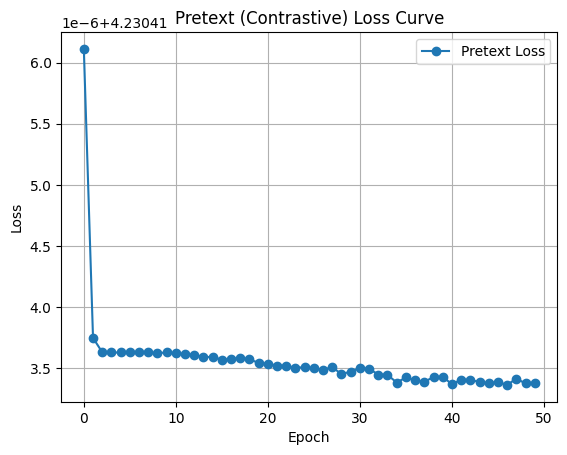

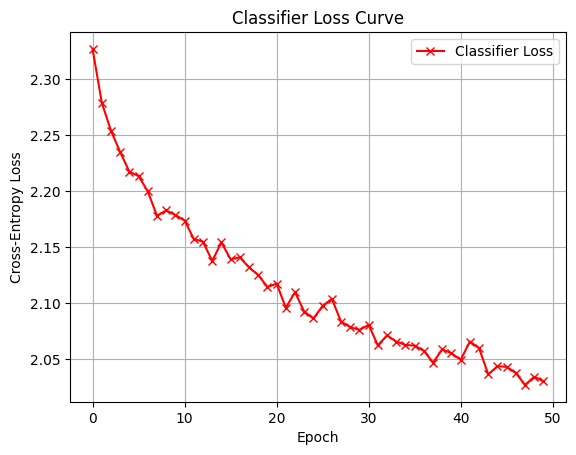

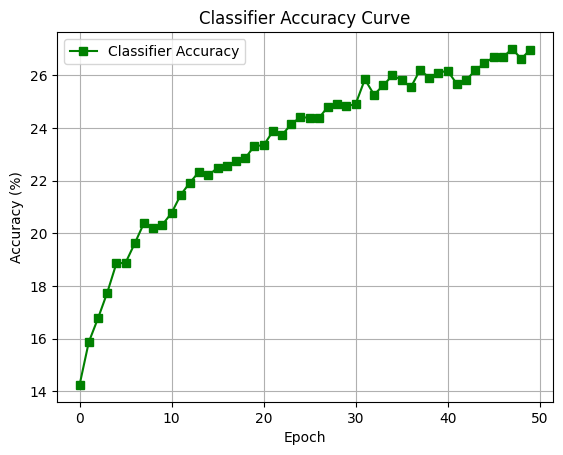

In [23]:
plt.figure()
plt.plot(pretext_losses, marker='o', label='Pretext Loss')
plt.title('Pretext (Contrastive) Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(downstream_losses, marker='x', color='red', label='Classifier Loss')
plt.title('Classifier Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(downstream_accuracies, marker='s', color='green', label='Classifier Accuracy')
plt.title('Classifier Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()